# General description of PSA_tool

## Introduction

PSA_tool have the main objetive to implement a analyse the allosteric communication, based on a structural alphabet, the Protein Blocks (PBs). The model of this program is GSA-tools, developped by Fraternalli *et al.* in 2013 (article), which analyze the trajectories of molecular dynamique by the use of a strucural alphabet. This approach was based on a succession of statistic analyze for predict the allosteric mouvment in a protein. However, GSA-tools use a old version of Gromacs, and was not totally useable.

Here we implement the same statistic analyse but based on the PBs alphabet, which are provide by a free use software : PBxplore.

## Installation:

The psa_tool program is available on this [GitHub reprository](https://github.com/n-robillard/psa_tool). The first step is to clone the reprository and create the right conda environment to that:

``` bash
$ git clone https://github.com/n-robillard/psa_tool.git

$ cd psa_tool

$ conda create -f psa_tool_env.yml

```

## Utilisation:

To use psa_tool, it's first need to have specific files .pdb at differents frames after a stimulus, which are placed in a directory in the data directory. With our exemple:

```bash
.../data/calf1_wt
```

After, we nedd to be replace in the main directory, `psa_tool`, and run the following command:

```bash
$ cd ..
$ pwd
.../psa_tool

$ python ./src/psa_tool.py
```

Now, we will detailed the fonctionning of psa_tool.


## I) Select the specific pdb file and compute PBxplore assignement

In the first part of the program, we need to assign the Protein Block alphabet to each pdb file. To do that, we first add criteria directly selected by the user.

In [1]:
import os
from shutil import copyfile

dir_name = ""
while dir_name == "":
    temp = input("Name of the directory where sample are stored in \"data\" : ")
    if os.path.exists("../data/"+dir_name):
        dir_name = temp
    else:
        print("Directory doesn't exist !")

files = os.listdir("../data/"+dir_name)
pos = files[0].rfind("_") + 1
file_row = files[0][:pos]
start = int(input("Please enter the time where the analyse start : "))
end = 0
while end <= start:
    end = int(input("Please enter the time where the analyse end : "))
step = int(input("Please, enter the time between every steps : "))
current = start
while current <= end:
    file_name = file_row + str(current) + ".pdb"
    copyfile("../data/"+ dir_name +"/"+ file_name, "../data/temp/" + file_name)
    current += step

Name of the directory where sample are stored in "data" :  calf1_wt
Please enter the time where the analyse start :  0
Please enter the time where the analyse end :  800
Please, enter the time between every steps :  5


On this example, we use the calf1 wild type motion, provide by our reporters, with 851 frames.

At this point, the program just copy the files needed into a directory name "temp" in data. After that, we need to use PBassign from PBxplore to determined the Protein Blocks (PBs) for make the statistic analysis.

In [2]:
os.system('PBassign -p ../data/temp' + ' -o ../data/sequences')

Read 1 chain(s) in ../data/temp/WT_20.pdb
Read 1 chain(s) in ../data/temp/WT_25.pdb
Read 1 chain(s) in ../data/temp/WT_30.pdb
Read 1 chain(s) in ../data/temp/WT_35.pdb
Read 1 chain(s) in ../data/temp/WT_40.pdb
Read 1 chain(s) in ../data/temp/WT_45.pdb
Read 1 chain(s) in ../data/temp/WT_50.pdb
Read 1 chain(s) in ../data/temp/WT_55.pdb
Read 1 chain(s) in ../data/temp/WT_60.pdb
Read 1 chain(s) in ../data/temp/WT_65.pdb
Read 1 chain(s) in ../data/temp/WT_70.pdb
Read 1 chain(s) in ../data/temp/WT_75.pdb
Read 1 chain(s) in ../data/temp/WT_80.pdb
Read 1 chain(s) in ../data/temp/WT_85.pdb
Read 1 chain(s) in ../data/temp/WT_90.pdb
Read 1 chain(s) in ../data/temp/WT_95.pdb
Read 1 chain(s) in ../data/temp/WT_100.pdb
Read 1 chain(s) in ../data/temp/WT_0.pdb
Read 1 chain(s) in ../data/temp/WT_5.pdb
Read 1 chain(s) in ../data/temp/WT_10.pdb
Read 1 chain(s) in ../data/temp/WT_15.pdb
Read 1 chain(s) in ../data/temp/WT_105.pdb
Read 1 chain(s) in ../data/temp/WT_110.pdb
Read 1 chain(s) in ../data/temp/W

161 PDB file(s) to process
wrote ../data/sequences.PB.fasta


0

We have now a file `sequences.PB.fasta`, which provide the trajectories for every pdb frames we selected.

## II) Parsing the fasta file and make it in a right form

After compute the PBassign of PBxplore, we need to import the sequences in the fasta file into Python. To do that, we use the `SeqIO` fonction of `biopython`. We import all the sequences into a `numpy` array, named `fasta_parsed`, with one sequence. The fasta file is imported in python but have some defaults: first, we have one frame by rows and columns represent each fragments. For make the statistic analyze more easier, we transpose the matrix. One more default of this array is inherent to the PBxplore : the 'Z' "trajectory". PBxplore analyze the trajectories of each amino acide *n* by the relation with amino acids *n-2*, *n-1*, *n+1*, *n+2*, which are impossible for the the two first and twor last amino acids. Even the calculation statistics parameters aren't possible (cause of the ordinal placment, see more in details in the statistic part), it's preferable to eliminated the two first and two last fragments, wich reduce a little the time of calculation. More of that, the 'Z' not represent a trajectory, but the impossibility of calculate it (as NA or NaN represent the absence of value), so it's not macking sense to calculated statistics on thats fragments.

To do that in a proper way, we defined a class, named `Fasta`, which do every of this steps :

In [3]:
from Bio import SeqIO
import numpy as np

class Fasta:
    def __init__(self, file_name):
        fasta_file = open(file_name)
        allSeqs = []
        for seq_record in SeqIO.parse(fasta_file, """fasta"""):
            allSeqs.append(seq_record.seq)
        self.pb_seq = np.array(allSeqs)
    def get_transpose(self):
        sequences = self.pb_seq.transpose()
        sequences = sequences[2:-2]
        return sequences

In [4]:
fasta = Fasta("../data/sequences.PB.fasta")
fasta_pbs = fasta.get_transpose()
print(fasta_pbs)

[['k' 'k' 'k' ... 'f' 'f' 'b']
 ['g' 'l' 'l' ... 'b' 'b' 'd']
 ['c' 'm' 'c' ... 'f' 'a' 'c']
 ...
 ['d' 'd' 'd' ... 'd' 'd' 'd']
 ['d' 'd' 'd' ... 'd' 'd' 'd']
 ['d' 'd' 'd' ... 'e' 'e' 'd']]


At this point, we have a now a formated numpy array, wich contained a every trajectory for each fragments in rows. At this point, we can perform statistical analysis to determine the correlation between trajectories.



## III) Statistical analysis on trajectories

In the article of Pandini *et al.*, they use a statistical model to determined the correlation between local motions. In this aspect they determined a normalized mutual information, based on three different statistics information : the mutual information, the joint entropy and the expected error of the mutual information. Here, we implement the same approach to our strucural alphabet.

### 1) Matrixes of probabilities

To compute the differents statistic parameters, we have first to generate some probability matrix, much needed for the mutual information, his expected error and the joint entropy. To do that, we calculate the probability of have letters (or trajectories) at every frames, and between every frames, that know as $p(x)$ and $p(x,y)$ :

In [5]:
def calculate_p(frame, weight):
    matrix= np.zeros((16)) #initialization of matrix
    for i in range(0,len(frame)):
        index_row = ord(frame[i])-97 #discretisation of the alphabet in int number (based on ASCII coding)
        matrix[index_row] += weight
    return matrix

def calculate_pxy(frame_src, frame_target, weight):
    matrix= np.zeros((16,16)) #initialization of matrix
    for i in range(0,len(frame_src)):
        index_row = ord(frame_src[i])-97 #discretisation of the alphabet in int number (based on ASCII coding)
        index_col = ord(frame_target[i])-97
        matrix[index_row,index_col] += weight
    return matrix

### 2) The mutual information

The first statistical parameter is the mutual information. In article of Pandini *et al* and in the GSA tools software, they calculated the mutual information *I(X;Y)* as the following equation:

$
I(X;Y)=\sum_{x\in X}\sum_{y\in Y} p(x,y)log_2(\frac{p(x,y)}{p_1(x) p_2(y)})
$

To implement that, we defined a fonction `calculate_MI` as:

In [6]:
import math

def calulate_mi(px, py, pxy):
    size = len(px)
    mi = 0
    for i in range(0,size):
        for j in range(0,size):
            if pxy[i,j] != 0:
                mi += pxy[i,j] * math.log2(pxy[i,j]/(px[i]*py[j]))
        if mi > 0:
            return mi
        else:
            return 0 

### 3) The joint entropy

On the same approach, the joint entropy is defined as *H(X;Y)*:

$
H(X;Y)=\sum_{x\in X}\sum_{y\in Y} p(x,y)log_2 p(x,y)
$

In [17]:
def calculate_joint_entropy(pxy):
    size = len(pxy)
    joint_entropy = 0
    for i in range(0,size):
        for j in range(0,size):
            if pxy [i,j] !=0:
                joint_entropy -= pxy[i,j] * math.log2(pxy[i,j])
    if joint_entropy != 0:
        return joint_entropy
    else:
        return 0

### 4) The expected error of the mutual information

The third parameter needed for the normalized mutual information is the expected error. In fact, the calculation of the information theoretical quantities on a finite size sample is affected by random errors, inherent to the sample, which are negligeable in the case of Shanon's entropy, but affect the mutual information calculs. In this case, Roulston *et al.* () present a method to improve this calcul, which used the expect error on the MI. This error is calculated as:

$
\varepsilon (X;Y) = \frac{B^*_{XY} - B^*_X - B^*_Y +1}{2N}
$

Where $B^*_{XY}$ , $B^*_X$ , $B^*_Y$ are the count of probability different of zero in the stat *(X;Y)*, *X* and *Y*, respectively.

On this purpose, we defiened a fonction which calculate this expected error as following:

In [8]:
def calculate_eemi(bxy, bx, by, n):
    return (bxy - bx - by + 1)/(2 * n)

### 5) The normalized mutual information

After calculate all of this statistical data,we obtained three differents matrixes, which have the same lenght than the sequences of the protein in row and columns. Each matrixes indicate the mutual information, the joint entropy and the expected error for each fragment against each other fragment. Then, we can calculated the normalized mutual information, defined as following:

$ 
I^n_{LL}(C_i;C_j)=\frac{I(C_i;C_j) - \varepsilon(C_i;C_j)}{H(C_i;C_j)}
$

For calculate this, we do a one fonction which aim to do the mutual information normalized and every other part of the statistic analysis:

In [9]:
def stats_analyze(frames_all):
    seq_size = len(frames_all[:,0])
    weight = 1 / seq_size
    mi = np.zeros((seq_size,seq_size))
    joint_entropy = np.zeros((seq_size,seq_size))
    eemi = np.zeros((seq_size,seq_size))
    normalized_mi = np.zeros((seq_size,seq_size))
    for i in range(0,len(frames_all)):
        for j in range(i,len(frames_all)):
            px = calculate_p(frames_all[i],weight) 
            py = calculate_p(frames_all[j],weight)
            pxy = calculate_pxy(frames_all[i],frames_all[j],weight)
            mi[i, j] = calulate_mi(px, py, pxy)
            joint_entropy[i, j] = calculate_joint_entropy(pxy)
            bx = np.count_nonzero(px)
            by = np.count_nonzero(py)
            bxy = np.count_nonzero(pxy)
            eemi[i, j] = calculate_eemi(bxy, bx, by, seq_size)
            if joint_entropy[i, j] != 0:
                normalized_mi[i, j] = (mi[i, j] - eemi[i, j])/joint_entropy[i, j]
            else:
                normalized_mi[i, j] = 0
            if i != j:
                mi[j, i]=mi[i, j]
                eemi[j, i]=eemi[i, j]
                joint_entropy[j, i]=joint_entropy[i, j]
                normalized_mi[j, i] = normalized_mi[i, j]
    return mi, eemi, joint_entropy, normalized_mi

In this fonction, only the numpy array of the fasta is needed to compute all of the model, and return the mutual information, the joint entropy, the mutual information and his expected error. every part of this analysis is wright in the `pb_analyze.py` file.

In [18]:
MI, eeMI, joint_entropy, normalized_MI = stats_analyze(fasta_pbs)

In [11]:
print(MI)

[[5.18104532e-02 2.65591275e-02 1.75006742e-02 ... 3.12041222e-04
  7.71477497e-05 5.66499261e-03]
 [2.65591275e-02 5.18104532e-02 1.43704311e-02 ... 3.12041222e-04
  7.71477497e-05 5.66499261e-03]
 [1.75006742e-02 1.43704311e-02 3.73574285e-01 ... 6.96204022e-03
  0.00000000e+00 4.92577552e-02]
 ...
 [3.12041222e-04 3.12041222e-04 6.96204022e-03 ... 2.58050830e-01
  2.47606445e-02 1.56231219e-04]
 [7.71477497e-05 7.71477497e-05 0.00000000e+00 ... 2.47606445e-02
  1.97652682e-01 9.03198326e-04]
 [5.66499261e-03 5.66499261e-03 4.92577552e-02 ... 1.56231219e-04
  9.03198326e-04 5.18104532e-02]]


In [12]:
print(eeMI)

[[-0.04744526  0.05109489  0.08029197 ...  0.05474453  0.04744526
   0.06934307]
 [ 0.05109489 -0.05109489  0.0620438  ...  0.04379562  0.04014599
   0.06569343]
 [ 0.08029197  0.0620438  -0.04744526 ...  0.04014599  0.04744526
   0.0729927 ]
 ...
 [ 0.05474453  0.04379562  0.04014599 ... -0.04014599 -0.01094891
   0.        ]
 [ 0.04744526  0.04014599  0.04744526 ... -0.01094891 -0.02919708
  -0.00729927]
 [ 0.06934307  0.06569343  0.0729927  ...  0.         -0.00729927
  -0.03284672]]


In [19]:
print(joint_entropy)

[[3.604289   5.18338683 5.67194968 ... 4.66573496 4.55154187 5.16529319]
 [5.18338683 3.76891392 5.5465039  ... 4.74535888 4.60368763 5.20510521]
 [5.67194968 5.5465039  3.62048259 ... 4.63703326 4.54137114 5.28726941]
 ...
 [4.66573496 4.74535888 4.63703326 ... 1.12336698 1.62442829 2.76438625]
 [4.55154187 4.60368763 4.54137114 ... 1.62442829 0.94140199 2.39747276]
 [5.16529319 5.20510521 5.28726941 ... 2.76438625 2.39747276 1.86613382]]


In [20]:
print(normalized_MI)

[[ 2.75382215e-02 -4.73353887e-03 -1.10704961e-02 ... -1.16664330e-02
  -1.04070465e-02 -1.23280656e-02]
 [-4.73353887e-03  2.73037129e-02 -8.59520976e-03 ... -9.16339108e-03
  -8.70363953e-03 -1.15326080e-02]
 [-1.10704961e-02 -8.59520976e-03  1.16288238e-01 ... -7.15628794e-03
  -1.04473416e-02 -4.48907436e-03]
 ...
 [-1.16664330e-02 -9.16339108e-03 -7.15628794e-03 ...  2.65449155e-01
   2.19828415e-02  5.65156983e-05]
 [-1.04070465e-02 -8.70363953e-03 -1.04473416e-02 ...  2.19828415e-02
   2.40970134e-01  3.42129785e-03]
 [-1.23280656e-02 -1.15326080e-02 -4.48907436e-03 ...  5.65156983e-05
   3.42129785e-03  4.53650040e-02]]


## IV) Vizualisaton

In this last part, we add a graphic representation for the normalized mutal information matrix matrix with the use of `matplotlib` and `seaborn`.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def matrix_plot(matrix):
    f, ax = plt.subplots(figsize=(15, 15)) 
    heatmap = sns.heatmap(matrix,
                      square=True,
                      linewidths = .5,
                      cmap ='Blues',
                      cbar_kws={"shrink": .4, 'ticks' : [-0.2, -0.1, 0.0, 0.1, 0.2]},
                      vmin = -0.2, 
                      vmax = 0.2,
                      )
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
    plt.title("Normalized Mutual Information")
    plt.xlabel("Fragment number")
    plt.ylabel("Fragment number")
    return heatmap

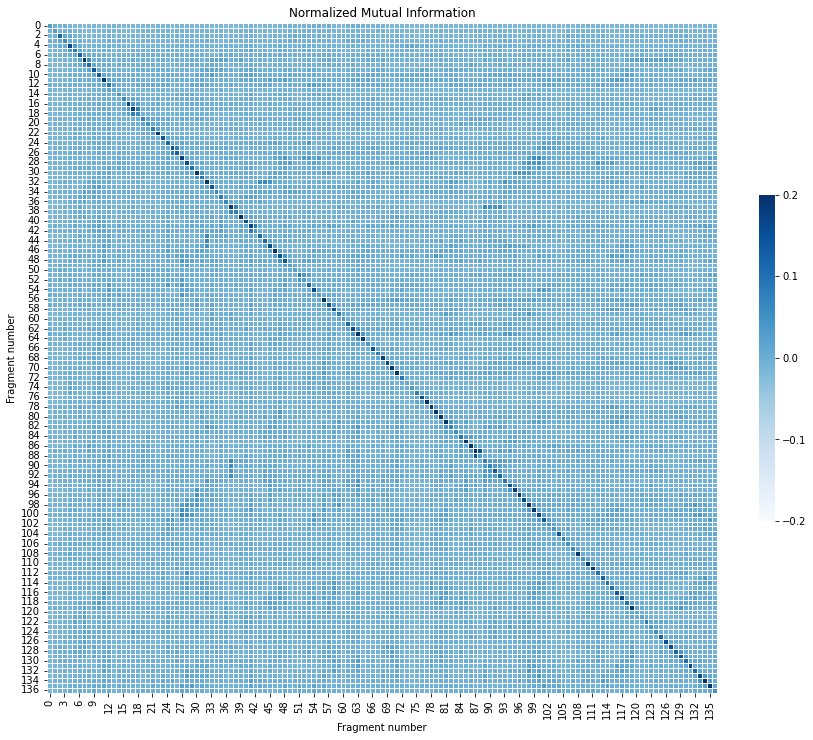

In [23]:
%matplotlib inline
vizu_nmi = matrix_plot(normalized_MI)

## V) Actual limit of the project

This work have lot of limits. First, all fonctions aren't defined to in objects, and the main upgrade of this code will be to make it. That provide a better managment of the errors, which is not really do at this step of the program. Another point, link to the first, is the entry provides by the user : they are a bit managed but not totaly one more time, the user can write specific unappropriate entries which gonna crash the program. If the code isn't start in the proprer directory, it may encounter some trouble to, and the data need to be stocked specificly in data, as well as the frames of motion need to have a consistant naming with an underscore before the number of the frame. More of that, the program make inconsistent results. The code need  to be make better to improve this critical step of programming. However, the program are need to create more graphics representation for describe all statistics approach, confirm local motion. The last but not the least, this program doesn't implement totaly the GSA-tools software, and on this point, it doesn't answer totaly on the suject, and it need to be improve in that way.


### References :

#### Bibliography:

- Pandini A, Fornili A, Fraternali F, Kleinjung J. "GSATools: analysis of allosteric communication and functional local motions using a Structural Alphabet", Bioinformatics, 2013, 29(16):2053-2055, 
- Pandini A, Fornili A, Fraternali F, Kleinjung J. "Detection of allosteric signal transmission by information-theoretic analysis of protein dynamics". FASEB J., 2012 Feb, 26(2):868-81.
- Jonathan Barnoud, Hubert Santuz,Pierrick Craveur, Agnel Praveen Joseph, Vincent Jallu, Alexandre G. de Brevern, Pierre Poulain, "PBxplore: A Tool To Analyze Local Protein Structure And Deformability With Protein Blocks". Peer J., 2017 Nov,
- Roulston M. "Estimating the errors on measured entropy and mutual information". Phys. D Nonlinear Phenomena, 1999, 125: 285–294
- Park B. H., Levitt M.  "The complexity and accuracy of discrete state models of protein structure". J. Mol. Biol., 1995, 249: 493–507
- Cover T. M., Thomas J. A. (1991) Elements of Information Theory, Wiley-Interscience, New York 

#### GitHub:

- [GSA-tools](https://github.com/AllosterIt/GSAtools)
- [PBxplore](https://github.com/pierrepo/PBxplore)
